In [1]:
import os
import sharedmem
import ctypes
import time
import numpy as np
import matplotlib.pyplot as plt
import popeye.utilities_cclab as utils
from popeye.visual_stimulus import VisualStimulus, simulate_bar_stimulus, resample_stimulus
from popeye.spinach import generate_og_receptive_fields
import popeye.models_cclab as prfModels
import threading
import multiprocessing as mp
# import popeye.css as css
# import popeye.utilities_cclab as utils
import nibabel as nib
from ipywidgets import interact, widgets
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from itertools import product
from scipy.optimize import brute, fmin, minimize, least_squares, fmin_powell
import pickle
from dataloader import *
from fit_utils import *
%load_ext autoreload
%autoreload 2
# %matplotlib inline

zod


In [5]:
truePath = '/d/DATA/data/popeye_pRF/Simulation/simulatedVoxels.pkl'
fitPath = '/d/DATA/data/popeye_pRF/Simulation/popeyeFit/RF_ss5_fFit_popeye.nii.gz'
fitData = nib.load(fitPath).get_fdata()
trueData = pickle.load(open(truePath, 'rb'))


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [8]:
trueData.shape

(10000, 201)

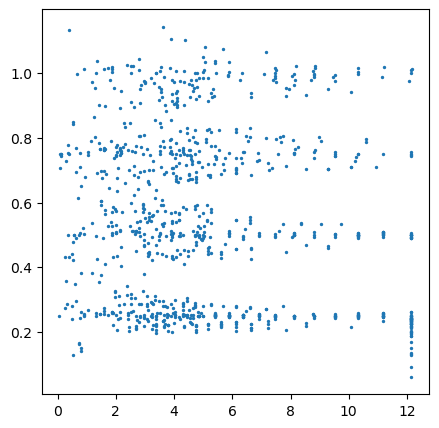

In [13]:
plt.figure(figsize=(5, 5))
plt.scatter(fitData[:, :, :, 3], fitData[:, :, :, 4], s=2)
# plt.scatter(trueData['params_vox'])
plt.show()

In [2]:
# viewing_distance = 38.0
# screen_width = 25.0
# thetas = np.arange(0, 360, 90)
# thetas = np.insert(thetas, 0, -1)
# thetas = np.append(thetas, -1)
# num_blank_steps = 30
# num_bar_steps = 30
# ecc = 12
# tr_length = 1.0
# frames_per_tr = 1.0
# scale_factor = 1.0
# pixels_across = 100
# pixels_down = 100
# dtype = ctypes.c_int16

# # Simulate the bar stimulus
# bar = simulate_bar_stimulus(pixels_across, pixels_down, viewing_distance, 
#                             screen_width, thetas, num_bar_steps, num_blank_steps, ecc)

# Initialize parameters
params = {}
params['subjID'] = 'JC'
# Got these from Zhengang, and he got it from rsvp_params.txt
params['viewingDistance'] = 83.5 #63 #83.5 # in cm
params['screenWidth'] = 36.2 #35 #36.2 # in cm
params['scaleFactor'] = 1
params['resampleFactor'] = 1
params['dtype'] = ctypes.c_int16

p = set_paths(params)

# Load stimulus
bar, stim_params = load_stimuli(p)
bar = bar[:, :, 0:201]
# Mirror y axis (this is done because popeye flips the y axis)
bar = np.flip(bar, axis=0)

# Create the visual stimulus
stimulus = VisualStimulus(stim_arr=bar,
                           viewing_distance=params['viewingDistance'], 
                           screen_width=params['screenWidth'], 
                           scale_factor=params['scaleFactor'], 
                           tr_length=1.3, 
                           dtype=ctypes.c_int16)

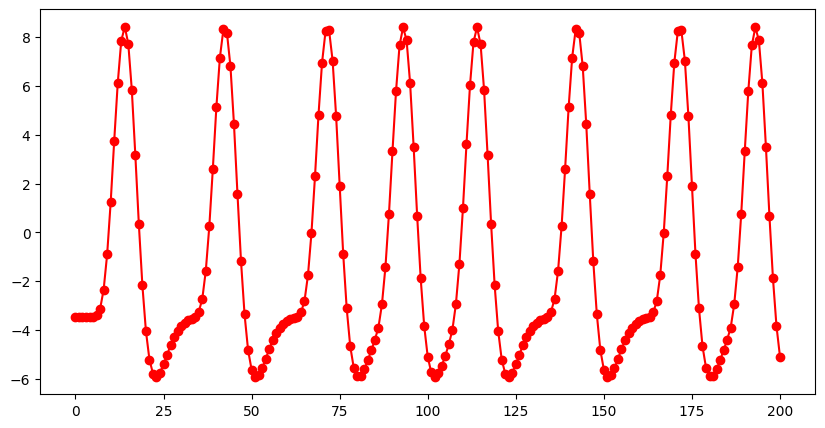

In [3]:
# Initialize a gaussian model
model = prfModels.CompressiveSpatialSummationModel(stimulus, utils.double_gamma_hrf)

model.hrf_delay = 0
model.mask_size = 5

# Generate simulated data
n_vox = 25
# Generate random pRF estimates for each voxel
ground_truth = np.empty((n_vox, 9))
ground_truth[:, 0] = np.random.uniform(-10, 10, n_vox) # x
ground_truth[:, 1] = np.random.uniform(-10, 10, n_vox) # y
ground_truth[:, 2] = np.random.uniform(0.25, 5, n_vox) # sigma
ground_truth[:, 3] = np.random.uniform(0.01, 1.0, n_vox) # exponent
ground_truth[:, 4] = np.random.uniform(0, 5, n_vox) # beta
ground_truth[:, 5] = np.random.uniform(-1, 1, n_vox) # baseline
ground_truth[:, 6] = np.ones((1,n_vox)) # R2
ground_truth[:, 7] = np.sqrt(ground_truth[:, 0]**2 + ground_truth[:, 1]**2) # eccentricity
ground_truth[:, 8] = np.mod(np.arctan2(ground_truth[:, 1], ground_truth[:, 0]),2*np.pi) # theta
# Create a holder for pRF estimates from the model
ballpark_estimates = np.empty((n_vox, ground_truth.shape[-1]))
param_estimates = np.empty((n_vox, ground_truth.shape[-1]))

sim_data = np.empty((n_vox, stimulus.stim_arr.shape[-1]))
for i in range(n_vox):
    sim_data[i, :] = model.generate_prediction(ground_truth[i,0], ground_truth[i,1], 
                                               ground_truth[i,2], ground_truth[i,3], 
                                               ground_truth[i,4], ground_truth[i,5])

plt.figure(figsize=(10, 5))
plt.plot(sim_data[1, :], 'ro-')
plt.show()

In [4]:
Ns=12
x_g = utils.grid_slice(-12, 12, Ns, dryrun=True)
y_g = utils.grid_slice(-12, 12, Ns, dryrun=True)
s_g = utils.grid_slice(0.1, 5.25, Ns, dryrun=True)
n_g = utils.grid_slice(0.01, 1.0, Ns, dryrun=True)

def ErrFunc(data, prediction):
    return np.nansum(data-prediction)**2
err_grid = np.empty((len(x_g), len(y_g), len(s_g), len(n_g)))
for (ix, iy, isig, iexp) in product(range(len(x_g)), range(len(y_g)), range(len(s_g)), range(len(n_g))):
    pred_this = model.generate_prediction(x_g[ix],y_g[iy], s_g[isig], n_g[iexp], ground_truth[1,4], ground_truth[1,5], unscaled=False)
    err_grid[ix, iy, isig, iexp] = ErrFunc(sim_data[1, :], pred_this)

zz = ErrFunc(sim_data[1, :], sim_data[1, :])

interactive(children=(IntSlider(value=0, description='elev', max=180), IntSlider(value=0, description='azim', …

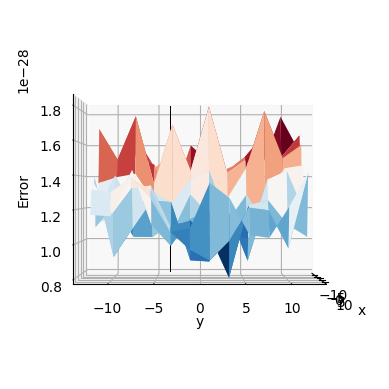

In [5]:
# Visualize the error grid as a 3d plot
# Make this interactive with the view angles
@interact(elev=widgets.IntSlider(min=0, max=180, step=1, value=0),
            azim=widgets.IntSlider(min=0, max=180, step=1, value=0),
            x_var=widgets.Dropdown(options=['x', 'y', 'sigma', 'exponent'], value='x', description = 'X-axis'),
            y_var=widgets.Dropdown(options=['x', 'y', 'sigma', 'exponent'], value='y', description = 'Y-axis'))
def plot_err(elev, azim, x_var, y_var):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if x_var == 'x':
        if y_var == 'y':
            X, Y = np.meshgrid(x_g, y_g)
            Z = np.mean(err_grid, axis=(2,3))
            xx, yy = ground_truth[1, 0], ground_truth[1, 1]
        elif y_var == 'sigma':
            X, Y = np.meshgrid(x_g, s_g)
            Z = np.mean(err_grid, axis=(1,3))
            xx, yy = ground_truth[1, 0], ground_truth[1, 2]
        elif y_var == 'exponent':
            X, Y = np.meshgrid(x_g, n_g)
            Z = np.mean(err_grid, axis=(1,2))
            xx, yy = ground_truth[1, 0], ground_truth[1, 3]
    elif x_var == 'y':
        if y_var == 'x':
            X, Y = np.meshgrid(y_g, x_g)
            Z = np.mean(err_grid, axis=(2,3))
            xx, yy = ground_truth[1, 1], ground_truth[1, 0]
        elif y_var == 'sigma':
            X, Y = np.meshgrid(y_g, s_g)
            Z = np.mean(err_grid, axis=(0,3))
            xx, yy = ground_truth[1, 1], ground_truth[1, 2]
        elif y_var == 'exponent':
            X, Y = np.meshgrid(y_g, n_g)
            Z = np.mean(err_grid, axis=(0,2))
            xx, yy = ground_truth[1, 1], ground_truth[1, 3]
    elif x_var == 'sigma':
        if y_var == 'x':
            X, Y = np.meshgrid(s_g, x_g)
            Z = np.mean(err_grid, axis=(1,3))
            xx, yy = ground_truth[1, 2], ground_truth[1, 0]
        elif y_var == 'y':
            X, Y = np.meshgrid(s_g, y_g)
            Z = np.mean(err_grid, axis=(0,3))
            xx, yy = ground_truth[1, 2], ground_truth[1, 1]
        elif y_var == 'exponent':
            X, Y = np.meshgrid(s_g, n_g)
            Z = np.mean(err_grid, axis=(0,1))
            xx, yy = ground_truth[1, 2], ground_truth[1, 3]
    elif x_var == 'exponent':
        if y_var == 'x':
            X, Y = np.meshgrid(n_g, x_g)
            Z = np.mean(err_grid, axis=(1,2))
            xx, yy = ground_truth[1, 3], ground_truth[1, 0]
        elif y_var == 'y':
            X, Y = np.meshgrid(n_g, y_g)
            Z = np.mean(err_grid, axis=(0,2))
            xx, yy = ground_truth[1, 3], ground_truth[1, 1]
        elif y_var == 'sigma':
            X, Y = np.meshgrid(n_g, s_g)
            Z = np.mean(err_grid, axis=(0,1))
            xx, yy = ground_truth[1, 3], ground_truth[1, 2]
    z_min, z_max = np.min(Z), np.max(Z)
    ax.bar3d(xx, yy, z_min, 0.1, 0.1, z_max-z_min, color='k')
    ax.plot_surface(X, Y, Z, cmap='RdBu_r')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)
    ax.set_zlabel('Error')
    plt.show()

plot_err(0, 0, 'x', 'y')

In [ ]:
plt.figure()
plt.hist(err_grid.flatten(), bins=100)
plt.show()

In [6]:
def error_func(params, data, objfunc):
    pred = objfunc(*params)
    return rss(pred, data)

def rss(pred, true):
    return np.sum((true-pred)**2)

def run_optimization(p0, bounds):
    output = minimize(error_func, p0, 
                      args=(sim_data[1, :], model.generate_prediction),
                      bounds=bounds, 
                      method='SLSQP')
    return bool(output.success), rss(output.x, ground_truth[1, 0:6])
# p0 = [0, 0, 0, 0, 0,0]

p0 = [0, 0, 0.01, 0.5, 0.1, 0.1]
# p0 = ground_truth[1, 0:6].copy()
Ns=3
x_g = utils.grid_slice(-12, 12, Ns, dryrun=True)
y_g = utils.grid_slice(-12, 12, Ns, dryrun=True)
s_g = utils.grid_slice(0.1, 5.25, Ns, dryrun=True)
n_g = utils.grid_slice(0.01, 1.0, Ns, dryrun=True)

x_bounds = (-15, 15)
y_bounds = (-15, 15)
s_bounds = (0.2, 10)
n_bounds = (0.001, 1.0)
b_bounds = (1e-8, None)
m_bounds = (None, None)
bounds = (x_bounds, y_bounds, s_bounds, n_bounds, b_bounds, m_bounds)
# grids = (x_g, y_g, s_g, n_g, )

# output = minimize(error_func, p0, 
#                   args=(sim_data[1, :], model.generate_prediction),
#                   bounds=[(-15, 15), (-15, 15), (0.2, 10), (0.001, 1.0), (1e-8, None), (None, None)], 
#                   method='SLSQP')
fitEnd_holder = np.empty((len(x_g), len(y_g), len(s_g), len(n_g)))
fitErr_holder = np.empty((len(x_g), len(y_g), len(s_g), len(n_g)))
for (ix, iy, isig, iexp) in product(range(len(x_g)), range(len(y_g)), range(len(s_g)), range(len(n_g))):
    p0 = [x_g[ix], y_g[iy], s_g[isig], n_g[iexp], 0.1, 0.1]
    fitEnd_holder[ix, iy, isig, iexp], fitErr_holder[ix, iy, isig, iexp] = run_optimization(p0, bounds)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [20]:
s, e

(True, 3.297012274975024)

## Trying out with custom gaussian function

In [ ]:
def gauss_func(x, y, sigma):
    return np.exp(-((x**2 + y**2)/(2*sigma**2)))

# Simulate data for a few voxels
n_vox = 25

